In [1]:
#Import all libraries
import os
import time
import csv
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import joblib
import gzip
import censusbatchgeocoder

In [2]:
#Set some global options
pd.set_option('max_colwidth', 100) #Its nice to see all columns


-----------------------

Let's start by reading in the 311 data, which as been downloaded locally as a CSV file.

In [3]:
df = pd.read_csv('data/311_sf.csv')
df.info()

/Users/pjandir/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2807867 entries, 0 to 2807866
Data columns (total 19 columns):
CaseID                 int64
Opened                 object
Closed                 object
Updated                object
Status                 object
Status Notes           object
Responsible Agency     object
Category               object
Request Type           object
Request Details        object
Address                object
Supervisor District    float64
Neighborhood           object
Police District        object
Latitude               float64
Longitude              float64
Point                  object
Source                 object
Media URL              object
dtypes: float64(3), int64(1), object(15)
memory usage: 407.0+ MB


In [4]:
df.sample(10)

,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Point,Source,Media URL
1763919,5415097,12/29/2015 07:34:28 PM,01/07/2016 09:57:50 AM,01/07/2016 09:57:50 AM,Closed,NaN,DPT SignShop Surveyed - Area 2 Queue,Sign Repair,Sign - Defaced,Other - Defaced; support - OK,"2233 IRVING ST, SAN FRANCISCO, CA, 94122",4.0,Outer Sunset,TARAVAL,37.76329,-122.4821,"(37.763206800612, -122.482059798538)",Mobile/Open311,http://mobile311.sfgov.org/media/san_francisco/report/photos/568350bcdf86e72091fea3c1/report.jpg
14898,312208,11/10/2008 07:40:55 PM,11/14/2008 02:06:57 PM,11/14/2008 02:06:57 PM,Closed,NaN,DPW Ops Queue,Graffiti,Graffiti on Building_commercial,Building_commercial - Offensive,"1000 SUTTER ST, SAN FRANCISCO, CA, 94109",3.0,Lower Nob Hill,CENTRAL,37.78820,-122.4170,"(37.7882, -122.417)",Phone,NaN
2112522,6414756,10/13/2016 08:10:06 AM,10/13/2016 11:33:11 AM,10/13/2016 11:33:11 AM,Closed,Pickup completed.,Recology_Abandoned,Encampments,Encampment items,Cart Pickup,"345 4TH ST, SAN FRANCISCO, CA, 94107",6.0,South of Market,SOUTHERN,37.78160,-122.4004,"(37.781606803713, -122.400361611379)",Phone,NaN
1616790,5007276,08/17/2015 03:03:24 PM,08/21/2015 01:54:36 AM,08/21/2015 01:54:36 AM,Closed,resolved: 10/98,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,"501 BEALE ST, SAN FRANCISCO, CA, 94107",6.0,South Beach,SOUTHERN,37.78622,-122.3896,"(37.7862, -122.39)",Phone,NaN
977597,2671819,08/02/2013 04:18:01 PM,08/02/2013 05:13:56 PM,08/02/2013 05:13:56 PM,Closed,work order made.,PUC - Water - G,Sewer Issues,Water_leak,Water_main,"1127 CAROLINA ST, SAN FRANCISCO, CA, 94107",10.0,Potrero Hill,BAYVIEW,37.75416,-122.3994,"(37.754162114357, -122.399437372939)",Phone,NaN
713821,1176650,07/28/2012 06:44:37 AM,07/30/2012 09:42:57 AM,07/30/2012 09:42:57 AM,Closed,ADMIN CLOSED,DPT Signal Queue,Damaged Property,Damaged Traffic_Signal,Traffic_Signal,Intersection of CESAR CHAVEZ ST and EVANS AVE,10.0,Produce Market,BAYVIEW,37.74968,-122.3973,"(37.7496845826706, -122.397285555195)",Phone,NaN
861636,2057608,02/25/2013 01:08:05 PM,02/26/2013 11:06:19 AM,02/26/2013 11:06:19 AM,Closed,Spoke with Paul about the the small business exemption & the $500 special tax credit for 2012.,Treasurer/Tax Collector - G,General Request - TT COLLECTOR,customer_callback,tt_collector - customer_callback,Not associated with a specific address,NaN,NaN,NaN,0.00000,0.0000,NaN,Phone,NaN
850014,1994947,02/08/2013 05:40:00 PM,02/11/2013 01:43:42 PM,02/11/2013 01:43:42 PM,Closed,psr 426711,SSP - MTA Feedback Queue,MUNI Feedback,MUNI - Conduct_Discourteous_Insensitive_Inappropriate_Conduct,301_Discourtesy_to_Customer,Not associated with a specific address,NaN,NaN,NaN,0.00000,0.0000,NaN,Web,NaN
463228,825363,02/13/2011 02:51:45 PM,02/15/2011 03:06:12 PM,02/15/2011 03:06:12 PM,Closed,NaN,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,"925 MISSION ST, SAN FRANCISCO, CA, 94103",6.0,South of Market,SOUTHERN,37.78230,-122.4068,"(37.782302694111, -122.40675740677)",Phone,NaN
12442,316324,11/18/2008 11:49:23 AM,11/19/2008 06:06:59 AM,11/19/2008 06:06:59 AM,Closed,NaN,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,"2632 MISSION ST, SAN FRANCISCO, CA, 94110",9.0,Mission,MISSION,37.75480,-122.4190,"(37.7548, -122.419)",Phone,NaN


We see there is something going on with the 18th column, **Media URL**. Let's take a look at that column. 

In [5]:
df['Media URL'].sample(10, random_state=42)

2740446                                                                                                    NaN
894105                                                                                                     NaN
2464408    http://mobile311.sfgov.org/media/san_francisco/report/photos/595f128f1ea5e5123537e43e/1499402856...
1983351                                                                                                    NaN
87873                                                                                                      NaN
1122483                                                                                                    NaN
2092736    http://mobile311.sfgov.org/media/san_francisco/report/photos/57eaf964df8624b637eb0e4d/photo_2016...
1309211                                                                                                    NaN
561781                                                                                                     NaN
1

It seems this column shows any photo or media sent in alongside the request. We probably do not need to know the exact media attached to a request. Instead let's replace that feature with a column that records whether or not a request had media linked to it. So we reduce that information to a simply binary response. 

In [6]:
df['Has_Media_Link'] = np.where(df['Media URL'].isnull(), True, False)
df.drop('Media URL', axis=1, inplace=True)

Next, we know this is time series data so let's make sure the time features are seen as such by $pandas$.

In [7]:
df.Opened  = pd.to_datetime(df.Opened , format="%m/%d/%Y %H:%M:%S %p")
df.Closed  = pd.to_datetime(df.Closed , format="%m/%d/%Y %H:%M:%S %p")
df.Updated = pd.to_datetime(df.Updated, format="%m/%d/%Y %H:%M:%S %p")

We can check what time period this dataset covers. 

In [8]:
print(df.Opened.min())
print(df.Opened.max())

2008-07-01 01:00:00
2018-02-09 12:30:00


Nearly an entire decade is covered. How is it distributed through the years?

In [9]:
df.set_index('Opened')['CaseID'].resample('A').count()

Opened
2008-12-31     67873
2009-12-31    173321
2010-12-31    186205
2011-12-31    195426
2012-12-31    213212
2013-12-31    287654
2014-12-31    310974
2015-12-31    346558
2016-12-31    451905
2017-12-31    512727
2018-12-31     62012
Freq: A-DEC, Name: CaseID, dtype: int64

Now, since we want to ultimately model the requests data, we will throw out the first partial year. Let's do that.

In [10]:
df = df[(df.Opened > '01/01/2009')]

We also notice that there are lots of **Addresses** that are not known. Let's make those null values more obvious. 

In [11]:
print(len(df[df.Address == 'Not associated with a specific address']))
df.Address.replace('Not associated with a specific address', np.nan, inplace=True)

336264


Since we know there are null values in this data, let's quantify it. 

In [12]:
df.isnull().sum()/len(df)

CaseID                 0.000000
Opened                 0.000000
Closed                 0.036738
Updated                0.000000
Status                 0.000000
Status Notes           0.274784
Responsible Agency     0.000000
Category               0.000000
Request Type           0.000000
Request Details        0.015084
Address                0.122730
Supervisor District    0.122787
Neighborhood           0.157029
Police District        0.123460
Latitude               0.000000
Longitude              0.000000
Point                  0.122750
Source                 0.000000
Has_Media_Link         0.000000
dtype: float64

Considering the size of the dataset, there are not all too many missing values. Let's start though by removing the rows, or requests, with no **Address**. Remember there are nearly 3 million rows in this dataset, and as we will find out later, we will need to pare down the dataset. So we can drop these rows. 

In [13]:
df = df[df.Address.notnull()]

In addition to the actual **Address** of a request, we also have the **Latitude** and **Longitude**. We can plot these and hopefully see the outline of San Francisco. 

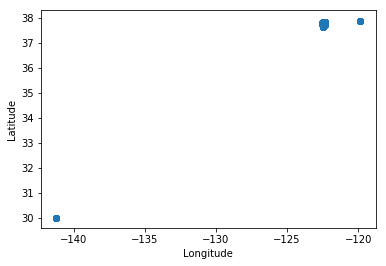

In [14]:
plt.scatter(df.Longitude, df.Latitude)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Interesting! There are some locations (well) outside San Francisco. In order to cut these rows out, we'll need a way to know what the outline of San Francisco is. We will do this by getting the locations of the designated US Census tracts for San Francisco. We can get the outline with a simple search through each tract. 

In [15]:
#Read in the geojson for SF
census_geo = pd.read_json('data/Census_2010_Tracts.geojson')

#Define the min/max values
min_lat, max_lat = np.inf, -np.inf
min_lon, max_lon = np.inf, -np.inf

#Brute-force search
for i in range(len(census_geo)):
    array = census_geo.features[i]['geometry']['coordinates'][0][0]
    for j in range(len(array)):
        lon, lat = array[j]
        if lat < min_lat:
            min_lat = lat
        if lat > max_lat:
            max_lat = lat
        if lon < min_lon:
            min_lon = lon
        if lon > max_lon:
            max_lon = lon             

In [16]:
pd.DataFrame({'Minimum': [min_lat, min_lon], 'Maximum': [max_lat, max_lon]}, index=['Latitude','Longitude'])

,Maximum,Minimum
Latitude,37.929824,37.639830
Longitude,-122.281780,-123.173825


Now, let's make sure all our rows reside within these boundaries. 

In [17]:
df = df[(((df.Longitude > min_lon) & (df.Longitude < max_lon)) & \
         ((df.Latitude  > min_lat) & (df.Latitude  < max_lat)))]

Now, we can re-plot it and check out an outline of San Francisco. 

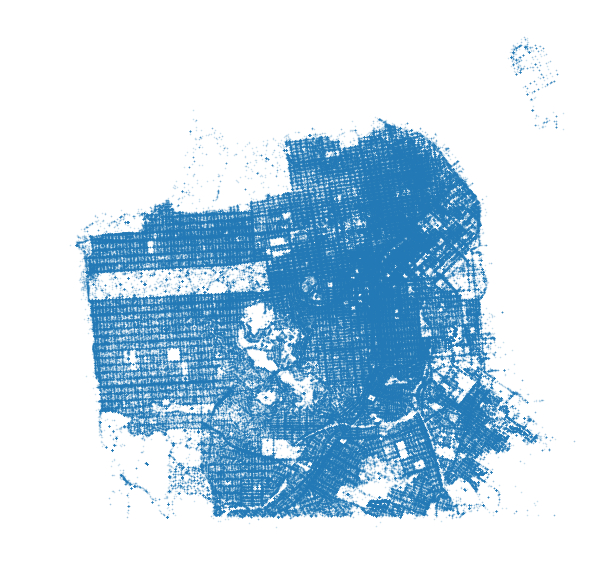

In [18]:
plt.figure(figsize=(10,10))
plt.scatter(df.Longitude, df.Latitude, alpha=0.2, s=0.4)
plt.axis('off')
plt.show()

Awesome! So we see a nice outline of the city, including Golden Gate Park (the sparse bar in the upper left). Moving on, we can check how much of our dataset remains. 

In [19]:
len(df)

2403628

So, we still have 2.4 million requests. The issue now is connecting each record with the US Census tract it originated from. The US Census provides an API which can return the Census Tract for a given address. The issue is that even with batch submission it takes around a half second for each given address. We can then estimate how long it would take to perform this task for the 2.4 million **Addresses** that we have.

In [20]:
len(df)*0.5/(60*60*24) #Convert to days

13.90988425925926

This would require nearly two full weeks! There might be alternate ways to do this, including potentially parallelizing the process, but in the interest of time we will have to cut down this dataset. We can start by limiting the number of **Categories** we are looking at. We can calculate what portion of the total data belongs to which **Categories**, cumulatively. 

In [21]:
(np.cumsum(df.Category.value_counts())/len(df)).head(20)

Street and Sidewalk Cleaning      0.307840
Graffiti                          0.474699
Abandoned Vehicle                 0.545376
Homeless Concerns                 0.602736
Encampments                       0.645724
Damaged Property                  0.681868
Sewer Issues                      0.711019
Streetlights                      0.736243
SFHA Requests                     0.761353
Tree Maintenance                  0.785304
Street Defects                    0.806045
Litter Receptacles                0.824963
Illegal Postings                  0.843626
MUNI Feedback                     0.862195
Rec and Park Requests             0.879490
Sign Repair                       0.896128
General Request - PUBLIC WORKS    0.912547
Sidewalk or Curb                  0.926586
General Request - MTA             0.937760
Temporary Sign Request            0.946468
Name: Category, dtype: float64

We can see that the top 8 **Categories** contain about ~74% of the total data. By dropping all other **Categories**, we can trim this dataset by over a quarter while keeping the most frequently requested services from the city. 

In [22]:
df = df[df.Category.isin(df.Category.value_counts()[:8].index)]

The API we will use is relatively stringent on the input. It needs to have a numbered address. However, not all of our **Addresses** have this. Certain **Addresses** just have the intersection of two streets. Others in some way are not easily parsable. In both cases, we will drop these offending rows.  

In [23]:
df = df[-df.Address.str.contains('Intersection')]
df = df[df.Address.str.count(',') == 3]

Finally, let's take a look again at how the data is distributed through the years. 

In [24]:
df.Opened.dt.year.value_counts().sort_index()/len(df)

2009    0.054598
2010    0.053372
2011    0.058025
2012    0.061889
2013    0.081200
2014    0.110463
2015    0.132605
2016    0.188293
2017    0.229718
2018    0.029838
Name: Opened, dtype: float64

Overall we see the increasing trend through the years. To reduce the size even further, we will keep only the 2015, 2016, and 2017 data. This ensures a full three years of data, while reducing the size. 

In [25]:
df = df[(df.Opened > '01/01/2015') & (df.Opened < '01/01/2018')]

In [26]:
len(df)

555345

Good, so now we have reduced our dataset to about a half million requests. This is much more manageable to grab the Census tract data we need. Let's now use the $censusbatchgeocoder$ library to translate (or geocode) our **Addresses** to **Tracts**. 

In [27]:
#Reset the index from all the row dropping
df.reset_index(inplace=True, drop=True)

In [28]:
#Batch limit is 10k
batch_size = 9000

#Loop over batch_size chunks of the dataset
for i in range(int(len(df)/batch_size)+1):
    
    #Check to see if we already did this chunk
    if os.path.exists('./data/geocoded_loc/geocode_%i.csv' % i):
        continue
    
    #Get the correct rows to slice
    lo = i*batch_size
    hi = (i+1)*batch_size
    if hi > len(df):
        hi = len(df)-1
        
    #Slice the data for this chunk    
    batch_df = pd.DataFrame(index=range(hi-lo), columns=['address','city','id','state','zipcode'])
    batch_df.address = df[lo:hi].Address.str.split(',').str[0].values
    batch_df.city    = df[lo:hi].Address.str.split(',').str[1].values
    batch_df.id      = df[lo:hi].CaseID.values
    batch_df.state   = df[lo:hi].Address.str.split(',').str[2].values
    batch_df.zipcode = df[lo:hi].Address.str.split(',').str[3].values
    
    #Get the geocoded tracts; keep trying if the connection fails
    start = time.time()
    while True:
        try:
            batchres = censusbatchgeocoder.geocode(batch_df.to_dict('records'))
            break
        except csv.Error, e:
            print('Uhoh - Loop %i: %s' % (i, e))

    #Print out the time it took        
    end = time.time()
    delta = end - start
    print('Loop #%i - %02d:%02d:%02d' % (i, delta//3600., delta//60., delta%60.))
    
    #Write out to file the success
    batch_res = pd.DataFrame(batchres) 
    batch_res = batch_res[['id','geocoded_address','tract','block']]
    batch_res.to_csv('./data/geocoded_loc/geocode_%i.csv' % i)

Excellent! This process takes a while (3+ days), but only needs to be done once. Now that we have this done, we can switch gears a little and build the demographic data we have. This was obtained from the US Census' FactFinder [website](https://factfinder.census.gov/faces/nav/jsf/pages/searchresults.xhtml?refresh=t). Let's first load in the datasets and get the **Tract**. 

In [29]:
df_pov  = pd.read_csv('data/poverty.csv'      , header=1)
df_inc  = pd.read_csv('data/median-income.csv', header=1)
df_emp  = pd.read_csv('data/unemployment.csv' , header=1)
df_dem1 = pd.read_csv('data/demographics1.csv', header=1)
df_dem2 = pd.read_csv('data/demographics2.csv', header=1)

df_pov ['Tract'] = df_pov .Geography.str.replace(',', '').str.split(' ').str.get(2)
df_inc ['Tract'] = df_inc .Geography.str.replace(',', '').str.split(' ').str.get(2)
df_emp ['Tract'] = df_emp .Geography.str.replace(',', '').str.split(' ').str.get(2)
df_dem1['Tract'] = df_dem1.Geography.str.replace(',', '').str.split(' ').str.get(2)
df_dem2['Tract'] = df_dem2.Geography.str.replace(',', '').str.split(' ').str.get(2)

Now, we can keep only the relevant columns from each individual dataframe. The idea is to merge these dataframes together first and then combine with the 311 data later. 

In [30]:
df_tot = df_pov.copy()

#Keep relevant columns only 
df_tot = df_tot[['Tract', 'All families  - Percent below poverty level; Estimate; Families']]

df_inc = df_inc[[
    'Tract', 
    'Estimate; INCOME AND BENEFITS (IN 2016 INFLATION-ADJUSTED DOLLARS) - Families - Median family income (dollars)'
]]

df_emp = df_emp[['Tract', 'Unemployment rate; Estimate; Population 16 years and over']]

df_dem1 = df_dem1[[
    'Tract',
    'Estimate; SEX AND AGE - Total population',
    'Percent; SEX AND AGE - Total population - Male',
    'Estimate; SEX AND AGE - Under 5 years',
    'Estimate; SEX AND AGE - 5 to 9 years',
    'Estimate; SEX AND AGE - 10 to 14 years',
    'Estimate; SEX AND AGE - 15 to 19 years',
    'Estimate; SEX AND AGE - 20 to 24 years',
    'Estimate; SEX AND AGE - 25 to 34 years',
    'Estimate; SEX AND AGE - 35 to 44 years',
    'Estimate; SEX AND AGE - 45 to 54 years',
    'Estimate; SEX AND AGE - 55 to 59 years',
    'Estimate; SEX AND AGE - 60 to 64 years',
    'Estimate; SEX AND AGE - 65 to 74 years',
    'Estimate; SEX AND AGE - 75 to 84 years',
    'Estimate; SEX AND AGE - 85 years and over'
]]

df_dem2 = df_dem2[[
    'Tract',
    'Estimate; HISPANIC OR LATINO AND RACE - Total population - Hispanic or Latino (of any race)',
    'Estimate; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - White alone',
    'Estimate; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Black or African American alone',
    'Estimate; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - American Indian and Alaska Native alone',
    'Estimate; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Asian alone',
    'Estimate; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Native Hawaiian and Other Pacific Islander alone',
    'Estimate; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Some other race alone',
    'Estimate; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Two or more races'
]]


Now, we can merge everything together.

In [31]:
df_tot = pd.merge(df_tot, df_inc, on='Tract', how='outer')
df_tot = pd.merge(df_tot, df_emp, on='Tract', how='outer')
df_tot = pd.merge(df_tot, df_dem1, on='Tract', how='outer')
df_tot = pd.merge(df_tot, df_dem2, on='Tract', how='outer')

We keep only the needed columns, again. 

In [32]:
df_tot.columns = [
    'Tract',
    'Poverty',
    'Income',
    'Unemployment',
    'Population',
    'Percent_Male',
    'Population_5',
    'Population_5_9',
    'Population_10_14',
    'Population_15_19',
    'Population_20_24',
    'Population_25_34',
    'Population_35_44',
    'Population_45_54',
    'Population_55_59',
    'Population_60_64',
    'Population_65_74',
    'Population_75_84',
    'Population_85',
    'Population_Hispanic',
    'Population_White',
    'Population_Black',
    'Population_Am_Indian',
    'Population_Asian',
    'Population_Pac_Island',
    'Population_Other1',
    'Population_Other2'
]

The population count columns are (re-)created appropriately. 

In [33]:
#Total populations by age
df_tot['Population_0_14']  = df_tot.Population_5     + df_tot.Population_5_9   + df_tot.Population_10_14
df_tot['Population_15_24'] = df_tot.Population_15_19 + df_tot.Population_20_24
df_tot['Population_25_64'] = df_tot.Population_25_34 + df_tot.Population_35_44 + df_tot.Population_45_54 + \
                             df_tot.Population_55_59 + df_tot.Population_60_64
df_tot['Population_65_up'] = df_tot.Population_65_74 + df_tot.Population_75_84 + df_tot.Population_85

#Total populations by race
df_tot['Population_Other'] = df_tot.Population_Other1 + df_tot.Population_Other2 + df_tot.Population_Am_Indian
df_tot['Population_Asian'] = df_tot.Population_Asian  + df_tot.Population_Pac_Island

#Percent populations by age
df_tot['Percent_Pop_0_14']  = df_tot.Population_0_14  / df_tot.Population
df_tot['Percent_Pop_15_24'] = df_tot.Population_15_24 / df_tot.Population
df_tot['Percent_Pop_25_64'] = df_tot.Population_25_64 / df_tot.Population
df_tot['Percent_Pop_65_up'] = df_tot.Population_65_up / df_tot.Population

#Percent populations by race
df_tot['Percent_Pop_White']    = df_tot.Population_White    / df_tot.Population
df_tot['Percent_Pop_Black']    = df_tot.Population_Black    / df_tot.Population
df_tot['Percent_Pop_Hispanic'] = df_tot.Population_Hispanic / df_tot.Population
df_tot['Percent_Pop_Asian']    = df_tot.Population_Asian    / df_tot.Population
df_tot['Percent_Pop_Other']    = df_tot.Population_Other    / df_tot.Population

We again only need some columns. 

In [34]:
df_tot = df_tot[[
    'Tract',
    'Poverty',
    'Income',
    'Unemployment',
    'Population',
    'Percent_Male',
    'Percent_Pop_0_14',
    'Percent_Pop_15_24',
    'Percent_Pop_25_64',
    'Percent_Pop_65_up',
    'Percent_Pop_White',
    'Percent_Pop_Black',
    'Percent_Pop_Hispanic',
    'Percent_Pop_Asian',
    'Percent_Pop_Other'    
]].copy()

There is a little bit of cleaning of the dataset which we can do now as well. 

In [35]:
df_tot.Income = df_tot.Income.str.replace('+', '').str.replace(',', '')

In [36]:
df_tot.replace('-', np.nan, inplace=True)

In [37]:
df_tot[['Tract', 'Poverty', 'Income', 'Unemployment', 'Percent_Male']] = \
df_tot[['Tract','Poverty', 'Income', 'Unemployment', 'Percent_Male']].apply(pd.to_numeric)

We can fill the small number of missing values as well here. 

In [38]:
df_tot[df_tot.Population==0] = df_tot[df_tot.Population==0].fillna(0)
df_tot.Poverty.fillna(0, inplace=True)
df_tot.Income.fillna(df_tot.Income.median(), inplace=True)

In [39]:
df_tot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197 entries, 0 to 196
Data columns (total 15 columns):
Tract                   197 non-null float64
Poverty                 197 non-null float64
Income                  197 non-null float64
Unemployment            197 non-null float64
Population              197 non-null int64
Percent_Male            197 non-null float64
Percent_Pop_0_14        197 non-null float64
Percent_Pop_15_24       197 non-null float64
Percent_Pop_25_64       197 non-null float64
Percent_Pop_65_up       197 non-null float64
Percent_Pop_White       197 non-null float64
Percent_Pop_Black       197 non-null float64
Percent_Pop_Hispanic    197 non-null float64
Percent_Pop_Asian       197 non-null float64
Percent_Pop_Other       197 non-null float64
dtypes: float64(14), int64(1)
memory usage: 24.6 KB


All seems OK with this combined demographic data now.

In [40]:
df_tot.sample(10)

,Tract,Poverty,Income,Unemployment,Population,Percent_Male,Percent_Pop_0_14,Percent_Pop_15_24,Percent_Pop_25_64,Percent_Pop_65_up,Percent_Pop_White,Percent_Pop_Black,Percent_Pop_Hispanic,Percent_Pop_Asian,Percent_Pop_Other
190,9802.00,0.0,155250.0,10.2,320,73.8,0.015625,0.028125,0.500000,0.456250,0.559375,0.100000,0.050000,0.271875,0.018750
189,615.00,4.0,199766.0,4.4,13057,53.5,0.084782,0.068009,0.793750,0.053458,0.512062,0.012407,0.087309,0.360267,0.027954
64,176.01,15.0,53136.0,4.0,7834,58.3,0.091907,0.088588,0.692877,0.126628,0.273041,0.099566,0.124457,0.435282,0.067654
164,353.00,5.2,94271.0,7.3,7514,45.4,0.144663,0.110594,0.545515,0.199228,0.230237,0.007985,0.067873,0.651184,0.042720
138,306.00,1.1,186875.0,6.4,2424,51.7,0.209571,0.080446,0.518564,0.191419,0.518152,0.005776,0.132838,0.298680,0.044554
194,9806.00,39.0,105139.0,14.1,476,54.6,0.117647,0.113445,0.573529,0.195378,0.157563,0.506303,0.235294,0.092437,0.008403
65,177.00,9.6,106838.0,10.4,1791,61.4,0.083194,0.099386,0.740369,0.077052,0.396985,0.022892,0.326633,0.145170,0.108319
136,304.00,1.8,168203.0,5.7,5568,46.5,0.152838,0.117816,0.558549,0.170797,0.479346,0.025144,0.036099,0.385955,0.073455
178,478.02,3.5,82276.0,4.3,3937,47.1,0.136144,0.155194,0.574041,0.134620,0.317755,0.000000,0.097790,0.541275,0.043180
139,307.00,1.0,145882.0,3.0,6673,53.7,0.167241,0.037914,0.600629,0.194215,0.522703,0.012138,0.120486,0.281283,0.063390


Now we can turn our attention to the geocoded **Addresses** from before. We load them in and concatenate them into a single dataframe.

In [41]:
allFiles = glob.glob('./data/geocoded_loc/geocode_*.csv')

dataframes = (pd.read_csv(f, index_col=None, dtype=object) for f in allFiles)
df_geo = pd.concat(dataframes, ignore_index=True).drop('Unnamed: 0', axis=1)

We can clean up this dataframe too. 

In [42]:
df_geo.columns = ['CaseID', 'Address', 'Tract', 'Block']

df_geo['Tract'] = pd.to_numeric(df_geo.Tract)/100.
df_geo[['CaseID', 'Block']] = df_geo[['CaseID', 'Block']].apply(pd.to_numeric)

In [43]:
df_geo.sample(10)

,CaseID,Address,Tract,Block
420162,7479629,"2719 16TH ST, SAN FRANCISCO, CA, 94103",177.00,2041.0
368026,7221632,"149 BLUXOME ST, SAN FRANCISCO, CA, 94107",607.00,1065.0
58645,5292823,"5200 MISSION ST, SAN FRANCISCO, CA, 94112",261.00,2024.0
70912,5485088,"1460 WEBSTER ST, SAN FRANCISCO, CA, 94115",159.00,1003.0
266870,6556127,"39 FELL ST, SAN FRANCISCO, CA, 94102",124.02,2017.0
420248,7480114,"175 GILBERT ST, SAN FRANCISCO, CA, 94103",180.00,2018.0
534610,4930070,"774 14TH ST, SAN FRANCISCO, CA, 94114",169.00,1002.0
208859,4589143,"1234 LARKIN ST, SAN FRANCISCO, CA, 94109",111.00,3001.0
208888,4589388,"751 MASON ST, SAN FRANCISCO, CA, 94108",119.02,1003.0
145258,5928917,"1330 16TH ST, SAN FRANCISCO, CA, 94103",607.00,2019.0


Now we can merge together the demographic dataframe with this one. 

In [44]:
df_cen = pd.merge(df_tot, df_geo, on='Tract', how='outer')
df_cen.sample(5)

,Tract,Poverty,Income,Unemployment,Population,Percent_Male,Percent_Pop_0_14,Percent_Pop_15_24,Percent_Pop_25_64,Percent_Pop_65_up,Percent_Pop_White,Percent_Pop_Black,Percent_Pop_Hispanic,Percent_Pop_Asian,Percent_Pop_Other,CaseID,Address,Block
422470,301.01,0.0,121643.0,4.9,4936.0,51.3,0.079822,0.040721,0.792747,0.086710,0.589344,0.023298,0.092585,0.219611,0.075162,5240880.0,"248 CARL ST, SAN FRANCISCO, CA, 94117",1000.0
267169,205.00,0.0,150179.0,3.2,2890.0,63.4,0.089965,0.029066,0.760900,0.120069,0.797924,0.020415,0.077509,0.071626,0.032526,6711215.0,"2450 MARKET ST, SAN FRANCISCO, CA, 94114",1001.0
471706,352.02,6.4,87143.0,3.6,4650.0,49.6,0.124301,0.093978,0.657849,0.123871,0.416129,0.021935,0.066022,0.421935,0.073978,7355219.0,"4055 JUDAH ST, SAN FRANCISCO, CA, 94122",3002.0
293374,208.00,4.2,67386.0,5.4,6292.0,60.7,0.073427,0.092339,0.724571,0.109663,0.334711,0.021456,0.421488,0.158137,0.064209,7103750.0,"233 CAPP ST, SAN FRANCISCO, CA, 94110",1000.0
377360,253.00,8.2,124234.0,2.1,4349.0,53.5,0.129225,0.068292,0.699471,0.103012,0.540124,0.021384,0.249943,0.114739,0.073810,6184844.0,"147 PROSPECT AVE, SAN FRANCISCO, CA, 94110",1008.0


Finally, we merge back with the 311 data to create a single, cohesive dataframe. 

In [45]:
df = pd.merge(df, df_cen, on=['CaseID'], how='left')
df.sample(5)

,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,...,Percent_Pop_15_24,Percent_Pop_25_64,Percent_Pop_65_up,Percent_Pop_White,Percent_Pop_Black,Percent_Pop_Hispanic,Percent_Pop_Asian,Percent_Pop_Other,Address_y,Block
145540,5502451,2016-01-25 09:01:16,2016-01-26 05:37:18,2016-01-26 05:37:18,Closed,NaN,Clear Channel - Transit Queue,Graffiti,Graffiti on Transit_Shelter_Platform,Transit_Shelter_Platform - Not_Offensive,...,0.104969,0.626087,0.154658,0.134783,0.006004,0.287785,0.551967,0.019462,"1209 GENEVA AVE, SAN FRANCISCO, CA, 94112",1002.0
229197,6077757,2016-07-13 11:55:15,2016-08-09 01:10:46,2016-08-09 01:10:46,Closed,7/14/16 POSTED. RC,DPW Ops Queue,Graffiti,Graffiti on Other_enter_additional_details_below,Other_enter_additional_details_below - Offensive,...,0.090909,0.531370,0.269313,0.035425,0.005762,0.038412,0.911438,0.008963,"131 WAVERLY PL, SAN FRANCISCO, CA, 94108",2007.0
39412,4681592,2015-04-20 06:26:45,2015-04-29 07:08:37,2015-04-29 07:08:37,Closed,4-28-15 @ 1214 HRS #229,DPT Abandoned Vehicles Work Queue,Abandoned Vehicle,Abandoned Vehicles,DPT Abandoned Vehicles Low,...,0.107702,0.570999,0.223827,0.567389,0.037906,0.092659,0.222022,0.080024,"6555 JOHN MUIR DR, SAN FRANCISCO, CA, 94132",1011.0
341604,6798247,2017-02-02 07:47:37,2017-02-05 11:30:16,2017-02-05 11:30:16,Closed,NaN,DPW Ops Queue,Homeless Concerns,Human Waste,Human Waste,...,0.072076,0.787273,0.078871,0.390651,0.132208,0.158979,0.221993,0.096170,"1350 FOLSOM ST, SAN FRANCISCO, CA, 94103",2007.0
243114,6177431,2016-08-09 11:24:57,2016-08-11 08:32:41,2016-08-11 08:32:41,Closed,08/10/16 @ 0900 #85,DPT Abandoned Vehicles Work Queue,Abandoned Vehicle,Abandoned Vehicles,DPT Abandoned Vehicles Low,...,0.092407,0.611997,0.194542,0.449608,0.010538,0.049986,0.382059,0.107809,"495 44TH AVE, SAN FRANCISCO, CA, 94121",1004.0


About 1% of the geocoded **Addresses** did not have an associated **Tract**, so those rows are also now dropped.

In [46]:
df = df[df.Tract.notnull()].copy()

We can clean up the merged dataframe to get a fully cleaned dataset.

In [47]:
#Add feature for if request is closed or not
df['Is_Closed'] = df['Status'].map({'Closed': True, 'Open': False})

#Drop unnecessary columns and null rows
df.drop(['CaseID', 'Updated', 'Closed', 'Status Notes', 'Request Details','Address_x', 'Request Type', 
         'Responsible Agency', 'Neighborhood', 'Address_y', 'Point', 'Block', 'Status'], 
        axis=1, inplace=True)
df.dropna(how='any', inplace=True) #Drops several rows

#Visual clean-up
df.columns = df.columns.str.replace(' ', '_')
df.reset_index(inplace=True, drop=True)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546126 entries, 0 to 546125
Data columns (total 24 columns):
Opened                  546126 non-null datetime64[ns]
Category                546126 non-null object
Supervisor_District     546126 non-null float64
Police_District         546126 non-null object
Latitude                546126 non-null float64
Longitude               546126 non-null float64
Source                  546126 non-null object
Has_Media_Link          546126 non-null bool
Tract                   546126 non-null float64
Poverty                 546126 non-null float64
Income                  546126 non-null float64
Unemployment            546126 non-null float64
Population              546126 non-null float64
Percent_Male            546126 non-null float64
Percent_Pop_0_14        546126 non-null float64
Percent_Pop_15_24       546126 non-null float64
Percent_Pop_25_64       546126 non-null float64
Percent_Pop_65_up       546126 non-null float64
Percent_Pop_White       

In [49]:
df.sample(5)

,Opened,Category,Supervisor_District,Police_District,Latitude,Longitude,Source,Has_Media_Link,Tract,Poverty,...,Percent_Pop_0_14,Percent_Pop_15_24,Percent_Pop_25_64,Percent_Pop_65_up,Percent_Pop_White,Percent_Pop_Black,Percent_Pop_Hispanic,Percent_Pop_Asian,Percent_Pop_Other,Is_Closed
164044,2016-03-07 09:39:45,Abandoned Vehicle,7.0,INGLESIDE,37.73423,-122.4541,Web,False,307.00,1.0,...,0.167241,0.037914,0.600629,0.194215,0.522703,0.012138,0.120486,0.281283,0.063390,True
122082,2015-12-17 03:13:32,Street and Sidewalk Cleaning,9.0,MISSION,37.75712,-122.4183,Mobile/Open311,False,208.00,4.2,...,0.073427,0.092339,0.724571,0.109663,0.334711,0.021456,0.421488,0.158137,0.064209,True
4899,2015-01-14 09:13:50,Graffiti,5.0,PARK,37.76567,-122.4641,Web,True,301.01,0.0,...,0.079822,0.040721,0.792747,0.086710,0.589344,0.023298,0.092585,0.219611,0.075162,True
68061,2015-07-22 08:45:38,Graffiti,8.0,MISSION,37.76144,-122.4234,Mobile/Open311,False,207.00,4.2,...,0.064423,0.059586,0.814084,0.061908,0.647127,0.008319,0.143161,0.156703,0.044689,True
401982,2017-05-28 10:14:49,Street and Sidewalk Cleaning,3.0,CENTRAL,37.79837,-122.4080,Phone,True,107.00,20.2,...,0.084770,0.122345,0.566709,0.226175,0.185152,0.000000,0.056090,0.751679,0.007079,True


Great! With this, we now have our fully cleaned dataset ready for exploration and analysis. There are a little over 540K requests still in our dataset, about 20% of the original size. We can save this work and dataset, via pickle, to local disk. 

In [50]:
#Save this model to a pickle file
with gzip.GzipFile('cleaned_df.pkl.gz', 'wb') as file:  
    joblib.dump(df, file)

-----------------------

Et fin.